In [1]:

import Paths.Paths as paths

from dendrocat import RadioSource
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import sys
import importlib
from astropy.wcs import WCS
from regions import Regions, PixCoord
from astropy import stats
from itertools import chain
import dendrocat
Path = paths.filepaths()





/home/t.yoo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


 b3_id     b6_id   b3_xpix ...       alpha              alphaerr      
                           ...                                        
-------- --------- ------- ... ------------------ --------------------
93030993 226003591  7566.0 ... 2.9070058110677057  0.08655649961254532
93031160 226003728  7543.0 ... 2.3767020479367664  0.07805916289287036
93031210 226003758  7501.0 ... 2.2642516325496986  0.04057097146425142
93031450 226003857  7496.0 ... 3.1721916878975267  0.09157797184318602
93033120 226004857  7603.0 ... 2.8167819515945847 0.025168989200307825
93033295 226004920  7436.0 ...  2.410520903520766  0.09607887578373493
93033484 226004956  7423.0 ...  2.369063464013875  0.11360124939175423
93034136 226005138  8088.0 ... 0.5845638808545989  0.07695990638959421
93034470 226005314  7548.0 ... 2.1843018318736114   0.0165058962334504
93034661 226005339  7488.0 ... 2.2591924963568646 0.024780668380578064
     ...       ...     ... ...                ...                  ...
930194

KeyError: 'temp'

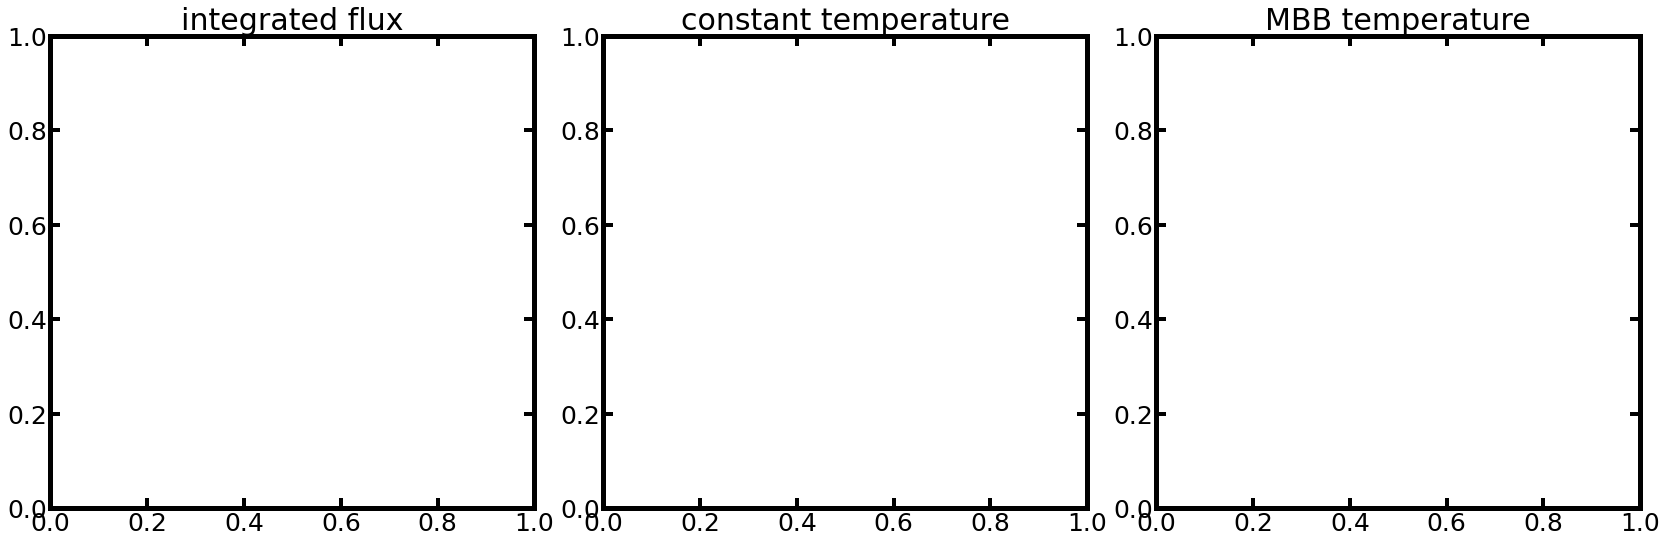

In [2]:



from astropy.table import Table
import matplotlib as mpl
import astropy.units as u
import astropy.constants as c
import seaborn as sns
from radio_beam import Beam
from astropy.io import ascii

plt.rcParams['axes.labelsize']=25
plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25
plt.rcParams['axes.titlesize']=25
mpl.rcParams['axes.linewidth'] = 5
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 4
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 4
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 2
params = {"xtick.top": True, "ytick.right": True, "xtick.direction": "in", "ytick.direction": "in"}
plt.rcParams.update(params)
class core_catdata():
    def __init__(self,catfile, almaimf_beam,  start_coreno, hrfits=None,band='B3', recommend_criteria = 'b6', include_ff='no' ):
        catdata_w51e = ascii.read(catfile,data_start=0,format='commented_header', header_start=120,  comment="!")
        geo_avg_beam = np.sqrt(almaimf_beam.major.to(u.arcsec).value*almaimf_beam.minor.to(u.arcsec).value)
        corr_factor = catdata_w51e['AFWHM02'] * catdata_w51e['BFWHM02'] / catdata_w51e['AFWHM03'] / catdata_w51e['BFWHM03']
        numcore_tot = len(catdata_w51e['AFWHM02'])
        if include_ff=='all':
            coreno_merged = start_coreno[0] + start_coreno[1]
            print('coreno_merged',coreno_merged)
            coreno_merged.sort()
            coreno_start = coreno_merged
            print('coreno_start',coreno_start)
        elif include_ff=='ffonly':
            coreno_start = start_coreno[1]
        elif include_ff=='no':
            coreno_start = start_coreno[0]
        coreidx_start = [i for i in range(numcore_tot) if catdata_w51e['NO'][i] in coreno_start]
        if recommend_criteria == 'b6b3':
            coreidx = [idx for idx in coreidx_start if all([np.abs(catdata_w51e['GOODM02'][idx])>1,  
                       np.abs(catdata_w51e['SIGNM02'][idx])>1,  
                       catdata_w51e['FXP_BST02'][idx]/catdata_w51e['FXP_ERR02'][idx]>2, 
                       catdata_w51e['FXT_BST02'][idx]/catdata_w51e['FXT_ERR02'][idx]>2, 
                       catdata_w51e['AFWHM02'][idx]/catdata_w51e['BFWHM02'][idx]<2 ,
                        catdata_w51e['FOOA02'][idx]/catdata_w51e['AFWHM02'][idx]>1.15 ,
                        np.sqrt(catdata_w51e['AFWHM03'][idx]*catdata_w51e['BFWHM03'][idx]) <4 * geo_avg_beam  ,
                        catdata_w51e['AFWHM03'][idx]/catdata_w51e['BFWHM03'][idx]<=2 ,
                        np.abs(catdata_w51e['SIGNM03'][idx])>1 ,
                        catdata_w51e['FXP_BST03'][idx]/catdata_w51e['FXP_ERR03'][idx]>1,  
                        catdata_w51e['FXT_BST03'][idx]/catdata_w51e['FXT_ERR03'][idx]>1])]
        elif recommend_criteria == 'b6':
            coreidx = coreidx_start                  
       
        
        if hrfits is not None:
            yso_image = fits.open(hrfits)[0].data[0][0]
            hrhdr = fits.open(hrfits)[0].header
            inside_idx = exist_inside_FOV(catdata_w51e['WCS_ACOOR'], catdata_w51e['WCS_DCOOR'], yso_image, hrhdr)
    
            rec_ind = np.intersect1d(coreidx, inside_idx)
        else:
            rec_ind = coreidx
        print('total core number = ', len(catdata_w51e['WCS_ACOOR']))
        print(hrfits)
        print('robust %s measurement before applying FoV criteria = '%band, len(coreidx))
        print('robust %s measurement after applying FoV criteria = '%band, len(rec_ind))
       
        self.sky_ra = catdata_w51e['WCS_ACOOR'][rec_ind]
        self.sky_dec = catdata_w51e['WCS_DCOOR'][rec_ind]
        self.pix_x = catdata_w51e['XCO_P'][rec_ind]
        self.pix_y = catdata_w51e['YCO_P'][rec_ind]
        
        if band=='B3':
            bandind = 3
        else:
            bandind = 2

        self.afwhm = catdata_w51e['AFWHM0%d'%bandind][rec_ind] #arcsec
        self.bfwhm = catdata_w51e['BFWHM0%d'%bandind][rec_ind]

        self.asize = catdata_w51e['ASIZE0%d'%bandind][rec_ind]
        self.bsize = catdata_w51e['BSIZE0%d'%bandind][rec_ind]

        self.theta = catdata_w51e['THETA0%d'%bandind][rec_ind]
        
        self.flux = catdata_w51e['FXT_BST0%d'%bandind][rec_ind]
        self.fluxerr = catdata_w51e['FXT_ERR0%d'%bandind][rec_ind]
        self.flux_g = catdata_w51e['FXT_ALT0%d'%bandind][rec_ind]

        self.fooa = catdata_w51e['FOOA0%d'%bandind][rec_ind]
        self.foob = catdata_w51e['FOOB0%d'%bandind][rec_ind]
        
        self.int_peak = catdata_w51e['FXP_BST0%d'%bandind][rec_ind]
        self.interr_peak = catdata_w51e['FXP_ERR0%d'%bandind][rec_ind]
        
        self.size = (catdata_w51e['AFWHM0%d'%bandind][rec_ind]*catdata_w51e['BFWHM0%d'%bandind][rec_ind]**2)**(1/3) #arcsec


        self.no = catdata_w51e['NO'][rec_ind]

        
        
        rescaled_3mmflux = catdata_w51e['FXT_BST03'][rec_ind] * catdata_w51e['AFWHM02'][rec_ind] * catdata_w51e['BFWHM02'][rec_ind] / catdata_w51e['AFWHM03'][rec_ind]/catdata_w51e['BFWHM03'][rec_ind]
        gamma = np.log10(catdata_w51e['FXT_BST02'][rec_ind] / rescaled_3mmflux)/np.log10(228.918/101.426)
        self.woffind = np.where(gamma>2)[0]
        self.wffind = np.where(gamma<2)[0]
        self.rec_ind = rec_ind

        
    def get_temperature(self,tempfile,temp100ind = [], temp300ind =[]):
        #temp100ind = hot cores with 100K
        #temp300ind = hot cores with 300K

        tab = ascii.read(tempfile, data_start=4)
        id = tab['col1']
        ra = tab['col2']
        dec = tab['col3']
        temp = tab['col4']

        """
        for i in range(len(self.sky_ra)):
            dist = np.sqrt((self.sky_ra[i]-ra)**2+(self.sky_dec[i]-dec)**2) #deg
            mindist = np.min(dist)
            if mindist<threshold:
                index = np.argmin(dist)
                temparr.append(temp[index])
            else:
                temparr.append(np.nan)
        """
        temparr = np.array([temp[np.where(id==no)[0]][0] for no in self.no])
        for i in range(len(temp100ind)):
            if temp100ind[i] in self.no:
                idx100 = np.where(self.no==temp100ind[i])[0]
                print(idx100)
                temparr[idx100] = 100
                print('#%d core temp -->100K'%temp100ind[i])
        for i in range(len(temp300ind)):
            if temp300ind[i] in self.no:
                idx300 = np.where(self.no==temp300ind[i])[0]
                temparr[idx300] = 300
                print('#%d core temp -->300K'%temp300ind[i])
        self.temp = np.array(temparr)*u.K
        
        return self.temp
    
    def get_tau(self, freq, omega):
        bb = models.BlackBody(temperature=self.temp)
    
        peak_int = (self.int_peak * u.Jy/u.beam).to(u.Jy/u.sr, equivalencies=u.beam_angular_area(omega))

        return -np.log(1 - (peak_int/ bb(freq).to(u.Jy/u.sr)).to(u.cm/u.cm).value)
    
    def get_coremass(self, freq, kappa, dist,omega):
            
        print('self.temp',self.temp)
        bb = models.BlackBody(temperature=self.temp)
        peak_int = (self.int_peak * u.Jy/u.beam).to(u.Jy/ u.sr, equivalencies=u.beam_angular_area(omega))
        print('peak_int',peak_int)
        print('self.flux',self.flux)
        print('kappa',kappa)
        print(bb(freq).to(u.Jy/u.sr))
        mass = - 1 / kappa * dist**2 * self.flux * u.Jy/ u.sr / peak_int * np.log(1 - (peak_int/ bb(freq).to(u.Jy/u.sr)).to(u.cm/u.cm).value)
        print((peak_int/ bb(freq).to(u.Jy/u.sr)).to(u.cm/u.cm).value)
        print(mass)
        print('mass',mass.to(u.Msun))
        self.mass = mass.to(u.Msun)
        return mass.to(u.Msun)
    
    def get_coremasserr(self):
        
        masserr = np.abs(self.mass * np.sqrt((self.fluxerr/self.flux)**2+(self.interr_peak/self.int_peak)**2))
        self.masserr = masserr
        return masserr.to(u.Msun)
                       
    def get_Jeansmass(self, dist=5400):
        rad = (self.afwhm.value*dist * self.bfwhm.value**2*dist**2)**(1/3) #arcsec -> au
        rho = self.mass / (4/3*np.pi * (rad*u.au)**3)
        c_s = np.sqrt(c.k_B*self.temp/2.8/c.m_p)
        jeans_mass = np.pi**(5/2)/6/c.G**(3/2) * c_s.to(u.cm/u.s)**3 * rho.to(u.g/u.cm**3)**(-1/2)
        
        return jeans_mass.to(u.Msun)

    def get_Jeansmasserr(self,dist=5400):
        rad = (self.afwhm.value*dist * self.bfwhm.value**2*dist**2)**(1/3) #arcsec -> au
        rho = self.mass / (4/3*np.pi * (rad*u.au)**3)
        c_s = np.sqrt(c.k_B*self.temp/2.8/c.m_p)
        jeans_mass = np.pi**(5/2)/6/c.G**(3/2) * c_s.to(u.cm/u.s)**3 * rho.to(u.g/u.cm**3)**(-1/2)
        rho_err = self.masserr / (4/3*np.pi * (rad*u.au)**3)

        jeans_mass_err = 0.5*jeans_mass * (rho_err/rho)

        return jeans_mass_err.to(u.Msun)
    def get_BE_mass(self, dist=5400):
        rad = (self.afwhm.value*dist * self.bfwhm.value**2*dist**2)**(1/3)
        rho = self.mass / (4/3*np.pi * (rad*u.au)**3)

        BE_mass = 1.18 * np.sqrt((c.k_B*self.temp/2.33/c.m_p/c.G)**3/rho).to(u.Msun)
        return BE_mass.to(u.Msun)
    
    def get_BE_masserr(self, dist=5400):
        rad = (self.afwhm.value*dist * self.bfwhm.value**2*dist**2)**(1/3)
        rho = self.mass / (4/3*np.pi * (rad*u.au)**3)

        BE_mass = 1.18 * np.sqrt((c.k_B*self.temp/2.33/c.m_p/c.G)**3/rho).to(u.Msun)
        rho_err = self.masserr / (4/3*np.pi * (rad*u.au)**3)

        BE_mass_err = 0.5*BE_mass * (rho_err/rho)
        return BE_mass_err.to(u.Msun)
    
    
    def multiplicity(self, hdrhr, xysource, almaimf_beam=None,issky=True, label=None, aperture='fwhm+beam',limitarea=None,  maxrad=1e3, verbose=False):
        ncat = len(self.no)
        if limitarea is not None:
            posind = np.where((sky_ra>limitarea[0])&(sky_ra<limitarea[1])&
                              (sky_dec>limitarea[2])&(sky_dec<limitarea[3]))[0]
        else:
            posind = np.arange(ncat)
        if label is None:
            label=np.arange(ncat)
        coreidx = np.arange(ncat)

        totalind = np.intersect1d(posind, label)
        print('totalind',totalind)
        sky_ra = self.sky_ra[totalind]
        sky_dec = self.sky_dec[totalind]
        fooa = self.fooa[totalind]
        foob = self.foob[totalind]
        theta = self.theta[totalind]
        no = self.no[totalind]
        afwhm =self.afwhm[totalind]
        bfwhm = self.bfwhm[totalind]

        skypos = np.vstack((sky_ra,sky_dec)).T


        wcshr = WCS(hdrhr,naxis=2)
        scalehr = wcshr.proj_plane_pixel_scales()[0]

        xypos_core = wcshr.wcs_world2pix(skypos,0)
        xpos_core = xypos_core[:,0]
        ypos_core = xypos_core[:,1]

        if issky:
            xysource_pix = wcshr.wcs_world2pix(xysource,0)
        else:
            xysource_pix = xysource
        ysonumarr=[] ; coreindarr=[]; ysoindarr=[]
        prestellar_ind = []
        protostellar_ind = []
        #print(xysource)
        for i in range(len(xypos_core)):
            if aperture is 'footprint':
                major = fooa[i]/3600/scalehr.value
                minor = foob[i]/3600/scalehr.value
                pa = theta[i]+90
            elif aperture is 'fwhm+beam':
                meanbeamsize = (almaimf_beam.major.value+almaimf_beam.minor.value)/4
                major = (afwhm[i]/3600+meanbeamsize)/scalehr.value
                minor = (bfwhm[i]/3600+meanbeamsize)/scalehr.value
                pa = theta[i]+90
            elif aperture is 'beam':
                major = almaimf_beam.major.value/scalehr.value
                minor = almaimf_beam.minor.value/scalehr.value
                pa = almaimf_beam.pa.value+90
            #if major > maxrad:
            #    continue

            numsource, indsource = count_points_in_ellipse(xpos_core[i],ypos_core[i],major,minor,pa,xysource_pix[:,0],xysource_pix[:,1])
            print(totalind[i], indsource, numsource)
            ysonumarr.append(numsource)
            coreindarr.append(totalind[i])
            ysoindarr.append(indsource)
            if numsource==0:
                prestellar_ind.append(totalind[i])
            elif numsource>0:
                protostellar_ind.append(totalind[i])
            
            
      
        ysoindarr_flat = []
        for arr in ysoindarr:
            ysoindarr_flat.extend(arr)
       
        print('cores with/without YSOs ', len(np.where(np.array(ysonumarr)!=0)[0]), len(xpos_core)-len(np.where(np.array(ysonumarr)!=0)[0]))
        print('YSOs associated with cores',len(np.unique(ysoindarr_flat)),' out of ',len(xysource_pix[:,0]))
              
        self.ysonumarr = ysonumarr
        self.coreindarr = coreindarr
        self.ysoindarr = ysoindarr
        self.prestellar_ind = prestellar_ind
        self.protostellar_ind = protostellar_ind
        print('pre,pro',self.prestellar_ind, self.protostellar_ind)
        return ysonumarr, coreindarr, ysoindarr, prestellar_ind, protostellar_ind
def count_points_in_ellipse(xcen,ycen,major,minor,pa,xpos,ypos):
    # caclulate foci positions 
    # must be full major, minor not semi major, minor
    fodx = np.cos(pa)*np.sqrt((major/2)**2-(minor/2)**2)
    fody = np.sin(pa)*np.sqrt((major/2)**2-(minor/2)**2)
    
    fox1 = xcen + fodx
    foy1 = ycen + fody
    
    fox2 = xcen - fodx
    foy2 = ycen - fody
    
    dist1 = np.sqrt((xpos-fox1)**2+(ypos-foy1)**2)
    dist2 = np.sqrt((xpos-fox2)**2+(ypos-foy2)**2)
    
    isinside = np.where(dist1+dist2<major)[0]
    
    return len(isinside), list(isinside)



def exist_inside_FOV(xcore_sky, ycore_sky, yso_image, hrhdr):
    isfinite = np.where(np.isfinite(yso_image))
    xfinite1 = np.min(isfinite[0])
    xfinite2 = np.max(isfinite[0])
    yfinite1 = np.min(isfinite[1])
    yfinite2 = np.max(isfinite[1])
     
    xcen = (xfinite1 + xfinite2)/2
    ycen = (yfinite1 + yfinite2)/2

    wcs_hr = WCS(hrhdr,naxis=2)
    xypos = wcs_hr.wcs_world2pix(np.vstack((xcore_sky,ycore_sky)).T,0)
    
    rad = np.abs(xfinite2 - xcen)
    
    
    dist = np.sqrt((xypos[:,0]- xcen)**2+(xypos[:,1]-ycen)**2)
    isinside = np.where(dist<rad)[0]
    
    return isinside        
def kappa(nu, nu0=271.1*u.GHz, kappa0=0.0114*u.cm**2*u.g**-1, beta=1.75):
    """
    Compute the opacity $\kappa$ given a reference frequency (or wavelength)
    and a power law governing the opacity as a fuction of frequency:
    $$ \kappa = \kappa_0 \left(\\frac{\\nu}{\\nu_0}\\right)^{\\beta} $$
    The default kappa=0.0114 at 271.1 GHz comes from extrapolating the
    Ossenkopf & Henning 1994 opacities for the thin-ice-mantle, 10^6 year model
    anchored at 1.0 mm with an assumed beta of 1.75.
    Parameters
    ----------
    nu: astropy.Quantity [u.spectral() equivalent]
        The frequency at which to evaluate kappa
    nu0: astropy.Quantity [u.spectral() equivalent]
        The reference frequency at which $\kappa$ is defined
    kappa0: astropy.Quantity [cm^2/g]
        The dust opacity per gram of H2 along the line of sight.  Because of
        the H2 conversion, this factor implicitly includes a dust to gas ratio
        (usually assumed 100)
    beta: float
        The power-law index governing kappa as a function of nu
    """
    return (kappa0*(nu.to(u.GHz,u.spectral())/nu0.to(u.GHz,u.spectral()))**(beta)).to(u.cm**2/u.g)

def get_mass(flux, kappa, freq, temp=40*u.K, dist=5.4*u.kpc, verbose=False):
    BB = 2 *np.pi * c.h * freq**3 / (c.c**2) / (np.e**(c.h*freq/(c.k_B*temp)) - 1)
    mass = flux.to(u.Jy) * dist**2 / BB.to(u.Jy) / kappa
    
    return mass.to(u.Msun)
hdrB6_w51e_almaimf = fits.getheader(Path.w51e_b6_almaimf)  
wcsB6_w51e_almaimf = WCS(hdrB6_w51e_almaimf,naxis=2)
beamb6_w51e_almaimf = Beam.from_fits_header(hdrB6_w51e_almaimf)  

hdrB3_w51e_almaimf = fits.getheader(Path.w51e_b3_almaimf)  
wcsB3_w51e_almaimf = WCS(hdrB3_w51e_almaimf,naxis=2)
beamb3_w51e_almaimf = Beam.from_fits_header(hdrB3_w51e_almaimf) 

hdrB6_w51n_almaimf = fits.getheader(Path.w51n_b6_almaimf)  
wcsB6_w51n_almaimf = WCS(hdrB6_w51n_almaimf,naxis=2)
beamb6_w51n_almaimf = Beam.from_fits_header(hdrB6_w51n_almaimf)  

hdrB3_w51n_almaimf = fits.getheader(Path.w51n_b3_almaimf)  
wcsB3_w51n_almaimf = WCS(hdrB3_w51n_almaimf,naxis=2)
beamb3_w51n_almaimf = Beam.from_fits_header(hdrB3_w51n_almaimf)  

hdrhr_w51n_b3= fits.getheader(Path.w51n_b3_tt0) 
hdrhr_w51e_b3= fits.getheader(Path.w51e_b3_tt0) 
hdrhr_w51n_b6= fits.getheader(Path.w51n_b6_tt0) 
hdrhr_w51e_b6= fits.getheader(Path.w51e_b6_tt0) 

catalog_w51e_yso = Table.read(Path.w51e_dendro_matched_catalog_new ,format='fits')
print(catalog_w51e_yso)


yso_w51e_xsky_b6 = catalog_w51e_yso['b6_xsky'] ; yso_w51e_ysky_b6 = catalog_w51e_yso['b6_ysky']
yso_w51e_xsky_b3 = catalog_w51e_yso['b3_xsky'] ; yso_w51e_ysky_b3 = catalog_w51e_yso['b3_ysky']

yso_detect_w51e_b6 = np.where(yso_w51e_xsky_b6>0)[0]
yso_detect_w51e_b3 = np.where(yso_w51e_xsky_b3>0)[0]


catalog_w51n_yso = Table.read(Path.w51n_dendro_matched_catalog_new ,format='fits')
yso_w51n_xsky_b6 = catalog_w51n_yso['b6_xsky'] ; yso_w51n_ysky_b6 = catalog_w51n_yso['b6_ysky']
yso_w51n_xsky_b3 = catalog_w51n_yso['b3_xsky'] ; yso_w51n_ysky_b3 = catalog_w51n_yso['b3_ysky']


yso_xsky_w51e = []
for i,x in enumerate(yso_w51e_xsky_b6):
    if x > 0:
        yso_xsky_w51e.append(x)
    else:
        yso_xsky_w51e.append(yso_w51e_xsky_b3[i])
yso_ysky_w51e = []
for i,x in enumerate(yso_w51e_ysky_b6):
    if x > 0:
        yso_ysky_w51e.append(x)
    else:
        yso_ysky_w51e.append(yso_w51e_ysky_b3[i])

yso_xsky_w51n = []
for i,x in enumerate(yso_w51n_xsky_b6):
    if x > 0:
        yso_xsky_w51n.append(x)
    else:
        yso_xsky_w51n.append(yso_w51n_xsky_b3[i])
yso_ysky_w51n = []
for i,x in enumerate(yso_w51n_ysky_b6):
    if x > 0:
        yso_ysky_w51n.append(x)
    else:
        yso_ysky_w51n.append(yso_w51n_ysky_b3[i])

yso_xysource_w51e= np.vstack((yso_xsky_w51e, yso_ysky_w51e)).T
yso_xysource_w51n= np.vstack((yso_xsky_w51n, yso_ysky_w51n)).T



coreidx_w51e_fabien = [[2,4,8,11,12,13,14,15,16,17,19,21,22,26,28,29,33,34,38,39],[1,3,5,6,9,10,18,27]] #30, 31, 20 are discarded because they have duplicated pairs in IRS2
coreidx_w51n_fabien = [[1,2,4,6,7,8,9,10,11,12,13,14,15,16,17,19,20,22,23,24,25,26,27,28,29,31,32,33,34,35,37,38,40,41,42,43,44,45,46,47,48,
49,51,52,53,54,55,57,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,84,85,86,87,88,89,90,91,92,94,95,97,99,100,101,102,104,105,106,107,108,109,111,114,117,119,122,123],
[3,5,18,36,56,58,98,113,118,124]]


hot_cores_w51e = [2,4]
hot_cores_w51n = [1,2,4,6,7,15,25,67 ]


core_catdata_w51e_b3_b6crit_b3fov = core_catdata(Path.w51e_almaimf_catalog, beamb3_w51e_almaimf,coreidx_w51e_fabien, hrfits=Path.w51e_b3_tt0)
core_catdata_w51e_b3_b6crit_b6fov = core_catdata(Path.w51e_almaimf_catalog, beamb3_w51e_almaimf, coreidx_w51e_fabien, hrfits=Path.w51e_b6_tt0)

core_catdata_w51n_b3_b6crit_b3fov = core_catdata(Path.w51n_almaimf_catalog, beamb3_w51n_almaimf,coreidx_w51n_fabien,hrfits = Path.w51n_b3_tt0)
core_catdata_w51n_b3_b6crit_b6fov = core_catdata(Path.w51n_almaimf_catalog, beamb3_w51n_almaimf,coreidx_w51n_fabien,hrfits =Path.w51n_b6_tt0)

multiplicity_w51e_b6crit_b3fov = core_catdata_w51e_b3_b6crit_b3fov.multiplicity(hdrhr_w51e_b3,yso_xysource_w51e,
                                 almaimf_beam = beamb6_w51e_almaimf)

multiplicity_w51n_b6crit_b3fov = core_catdata_w51n_b3_b6crit_b3fov.multiplicity(hdrhr_w51n_b3,yso_xysource_w51n,
                                 almaimf_beam = beamb6_w51n_almaimf,)

ppoidx_w51e_hot_core_associated_100K = [multiplicity_w51e_b6crit_b3fov[2][i] for i in range(len(core_catdata_w51e_b3_b6crit_b3fov.no)) if core_catdata_w51e_b3_b6crit_b3fov.no[i] in hot_cores_w51e]
ppoidx_w51n_hot_core_associated_100K = [multiplicity_w51n_b6crit_b3fov[2][i] for i in range(len(core_catdata_w51n_b3_b6crit_b3fov.no)) if core_catdata_w51n_b3_b6crit_b3fov.no[i] in hot_cores_w51n]

ppoidx_w51e_hot_core_associated_300K = [multiplicity_w51e_b6crit_b3fov[2][i] for i in range(len(core_catdata_w51e_b3_b6crit_b3fov.no)) if core_catdata_w51e_b3_b6crit_b3fov.no[i] in [2]]
ppoidx_w51n_hot_core_associated_300K = [multiplicity_w51n_b6crit_b3fov[2][i] for i in range(len(core_catdata_w51n_b3_b6crit_b3fov.no)) if core_catdata_w51n_b3_b6crit_b3fov.no[i] in [1]]


def flatten(xss):
    return [x for xs in xss for x in xs]
ppoidx_w51e_hot_core_associated_100K = flatten(ppoidx_w51e_hot_core_associated_100K)
ppoidx_w51n_hot_core_associated_100K = flatten(ppoidx_w51n_hot_core_associated_100K)
fig = plt.figure(figsize=(24,8))
ax1 = fig.add_axes([0.05,0.13,0.28,0.82])
ax2 = fig.add_axes([0.37,0.13,0.28,0.82])
ax3 = fig.add_axes([0.69,0.13,0.28,0.82])
ax1.set_title('integrated flux', fontsize=30)
ax2.set_title('constant temperature', fontsize=30)
ax3.set_title('MBB temperature', fontsize=30)

w51e_b3_flux_fits = Table.read(Path.w51e_b3_flux)
w51e_b6_flux_fits = Table.read(Path.w51e_b6_flux)
w51n_b3_flux_fits = Table.read(Path.w51n_b3_flux)
w51n_b6_flux_fits = Table.read(Path.w51n_b6_flux)
w51e_b3_int_flux = w51e_b3_flux_fits['flux']
w51e_b6_int_flux = w51e_b6_flux_fits['flux']
w51n_b3_int_flux = w51n_b3_flux_fits['flux']
w51n_b6_int_flux = w51n_b6_flux_fits['flux']
w51e_b3_int_flux_err = w51e_b3_flux_fits['flux_err']
w51e_b6_int_flux_err = w51e_b6_flux_fits['flux_err']
w51n_b3_int_flux_err = w51n_b3_flux_fits['flux_err']
w51n_b6_int_flux_err = w51n_b6_flux_fits['flux_err']


bins = np.logspace(-4,0,21)


w51ecat = Table.read(Path.w51e_dendro_matched_catalog_new)
w51ncat = Table.read(Path.w51n_dendro_matched_catalog_new)
temp_w51e = w51ecat['temp']
temp_w51n = w51ncat['temp']
group_w51e = w51ecat['group']
group_w51n = w51ncat['group']
ind_constT_w51e = np.where(group_w51e<2)[0]
ind_constT_w51n = np.where(group_w51n<2)[0]
cmap = sns.color_palette("colorblind")

ax1.hist(w51e_b3_int_flux[ind_constT_w51e], bins=bins, facecolor='none',edgecolor=cmap[0], histtype='step',label='W51-E 3mm',lw=4,alpha=0.8)
ax1.hist(w51e_b6_int_flux[ind_constT_w51e], bins=bins, color=cmap[-1],label='W51-E 1.3mm',lw=4,alpha=0.4)
ax1.hist(w51n_b3_int_flux[ind_constT_w51n], bins=bins, facecolor='none',edgecolor=cmap[1], histtype='step',label='W51-IRS2 3mm',lw=4,alpha=0.8,hatch='/')
ax1.hist(w51n_b6_int_flux[ind_constT_w51n], bins=bins, color=cmap[-2],label='W51-IRS2 1.3mm',lw=4,alpha=0.4)
ax1.set_xlabel(r'$F_{\rm int}$ (Jy)')
ax1.set_ylabel('$dN/dlogM$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e-5,1e-1)
ax1.set_xticks([1e-4,1e-3,1e-2,1e-1,1e0])
ax1.legend(fontsize=20,frameon=False,loc='upper right')

massbins = np.logspace(-3,3,31)
b3freq = 92982346121.91989*u.Hz
b6freq = 226691598706.70853*u.Hz
b3kappa = kappa(b3freq)
b6kappa = kappa(b6freq)
median_temp_w51e = np.ma.median(temp_w51e)

median_temp_w51n = np.ma.median(temp_w51n)
nanind_MBBT_w51e = np.where(~np.isfinite(temp_w51e))[0]
nanind_MBBT_w51n = np.where(~np.isfinite(temp_w51n))[0]






w51e_temp_const = np.ones(len(w51e_b3_int_flux))*40*u.K
w51n_temp_const = np.ones(len(w51n_b3_int_flux))*40*u.K
print('ho',len(ppoidx_w51e_hot_core_associated_100K), len(ppoidx_w51e_hot_core_associated_300K))
print(ppoidx_w51e_hot_core_associated_100K, ppoidx_w51e_hot_core_associated_300K)
print(len(ppoidx_w51n_hot_core_associated_100K), len(ppoidx_w51n_hot_core_associated_300K))
print(ppoidx_w51n_hot_core_associated_100K, ppoidx_w51n_hot_core_associated_300K)
w51e_temp_const[ppoidx_w51e_hot_core_associated_100K] = 100*u.K
w51e_temp_const[ppoidx_w51e_hot_core_associated_300K] = 300*u.K
w51n_temp_const[ppoidx_w51n_hot_core_associated_100K] = 100*u.K
w51n_temp_const[ppoidx_w51n_hot_core_associated_300K] = 300*u.K


w51e_b3_mass = get_mass(w51e_b3_int_flux, b3kappa,  b3freq, temp=w51e_temp_const, verbose=True)
w51e_b3_mass_err = get_mass(w51e_b3_int_flux_err, b3kappa,  b3freq, temp=w51e_temp_const)   

w51e_b6_mass = get_mass(w51e_b6_int_flux, b6kappa,  b6freq, temp=w51e_temp_const)   
w51n_b3_mass = get_mass(w51n_b3_int_flux, b3kappa,  b3freq, temp=w51n_temp_const)
w51n_b3_mass_err = get_mass(w51n_b3_int_flux_err, b3kappa,  b3freq, temp=w51n_temp_const)   
w51n_b6_mass = get_mass(w51n_b6_int_flux,  b6kappa, b6freq,temp=w51n_temp_const)
"""
w51e_b3_mass[nanind_MBBT_w51e] = np.nan
w51e_b6_mass[nanind_MBBT_w51e] = np.nan
w51n_b3_mass[nanind_MBBT_w51n] = np.nan
w51n_b6_mass[nanind_MBBT_w51n] = np.nan
w51e_b3_mass_upperr[nanind_MBBT_w51e] = np.nan
w51n_b3_mass_upperr[nanind_MBBT_w51n] = np.nan
w51e_b3_mass_lowerr[nanind_MBBT_w51e] = np.nan
w51n_b3_mass_lowerr[nanind_MBBT_w51n] = np.nan
"""
print(len(w51e_b3_mass), len(group_w51e))
print(group_w51e)
ax2.hist(w51e_b3_mass.value[ind_constT_w51e], bins=massbins, facecolor='none',edgecolor=cmap[0], histtype='step',label='W51-E',lw=4,alpha=0.8)
#ax2.hist(w51e_b6_mass.value[ind_w51e], bins=massbins, color='cyan',label='W51-E B6',lw=4,alpha=0.4)
ax2.hist(w51n_b3_mass.value[ind_constT_w51n], bins=massbins, facecolor='none',edgecolor=cmap[1], histtype='step',label='W51-IRS2',lw=4,alpha=0.8,hatch='/')
#ax2.hist(w51n_b6_mass.value[ind_w51n], bins=massbins, color='peru',label='W51-IRS2 B6',lw=4,alpha=0.4)
#ax2.hist(np.append(w51n_b3_mass.value,w51e_b3_mass.value), bins=massbins, facecolor='none',edgecolor='k', histtype='step',label='total',lw=4,alpha=0.8,ls='dashed')
ax2.legend(fontsize=20,frameon=False)
w51e_b3_mass2 = get_mass(w51e_b3_int_flux, b3kappa,  b3freq,temp=temp_w51e*u.K)
w51e_b3_mass2_err = get_mass(w51e_b3_int_flux_err, b3kappa,  b3freq, temp=temp_w51e*u.K)   


w51e_b6_mass2 = get_mass(w51e_b6_int_flux, b6kappa,  b6freq,temp=temp_w51e*u.K)   
w51n_b3_mass2 = get_mass(w51n_b3_int_flux, b3kappa,  b3freq,temp=temp_w51n*u.K)   
w51n_b3_mass2_err = get_mass(w51n_b3_int_flux_err, b3kappa,  b3freq,temp=temp_w51n*u.K)   
w51n_b6_mass2 = get_mass(w51n_b6_int_flux,  b6kappa, b6freq,temp=temp_w51n*u.K)
print('hoho,', get_mass([0.25, 0.20]*u.mJy, b3kappa,  b3freq,temp=40*u.K))
w51e_b3_mass2[nanind_MBBT_w51e] = np.nan
w51e_b6_mass2[nanind_MBBT_w51e] = np.nan
w51n_b3_mass2[nanind_MBBT_w51n] = np.nan
w51n_b6_mass2[nanind_MBBT_w51n] = np.nan
print(temp_w51e, temp_w51n)
ax3.hist(w51e_b3_mass2.value[ind_constT_w51e], bins=massbins, facecolor='none',edgecolor=cmap[0], histtype='step',label='W51-E',lw=4,alpha=0.8)
#ax3.hist(w51e_b6_mass2.value[ind_w51e], bins=massbins, color='cyan',label='W51-E B6',lw=4,alpha=0.4)
ax3.hist(w51n_b3_mass2.value[ind_constT_w51n], bins=massbins, facecolor='none',edgecolor=cmap[1], histtype='step',label='W51-IRS2',lw=4,alpha=0.8,hatch='/')
#ax3.hist(w51n_b6_mass2.value[ind_w51n], bins=massbins, color='peru',label='W51-IRS2 B6',lw=4,alpha=0.4)
#ax3.hist(np.append(w51n_b3_mass2.value,w51e_b3_mass2.value), bins=massbins, facecolor='none',edgecolor='k', histtype='step',label='total',lw=4,alpha=0.8,ls='dashed')
print(w51e_b3_mass2, w51n_b3_mass2)


ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'$M_{\rm YSO, constT}$ ($M_\odot$)')
#ax2.set_ylabel('YSO number')
ax2.set_xticks([1e-2,1e-1,1e0,1e1,1e2])
#ax2.legend(fontsize=20,frameon=False)
ax1.set_ylim(0.8,40)
ax2.set_ylim(0.8,40)
ax3.set_ylim(0.8,40)
ax1.set_xlim(5e-5,2e-1)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel(r'$M_{\rm YSO, MBBT}$ ($M_\odot$)')
#ax3.set_ylabel('YSO number')
ax3.set_xticks([1e-2,1e-1,1e0,1e1,1e2])
ax2.set_xlim(1e-1,3e2)
ax3.set_xlim(1e-1,3e2)
#ax3.legend(fontsize=20,frameon=False)
plt.savefig('flux_mass.png')
idx = [33,40,41]
print(w51e_b3_mass2[idx])
print(w51e_b3_mass[idx])
idx = [10]
print(w51n_b3_mass[idx])


In [ ]:
w51ecat['constT_mass'] = w51e_b3_mass
w51ncat['constT_mass'] = w51n_b3_mass
w51ecat['MBBT_mass'] = w51e_b3_mass2
w51ncat['MBBT_mass'] = w51n_b3_mass2
w51ecat['constT_mass_err'] = w51e_b3_mass_err
w51ncat['constT_mass_err'] = w51n_b3_mass_err
w51ecat['MBBT_mass_err'] = w51e_b3_mass2_err
w51ncat['MBBT_mass_err'] = w51n_b3_mass2_err

w51ecat.write(Path.w51e_dendro_matched_catalog_new, format='fits', overwrite=True)
w51ncat.write(Path.w51n_dendro_matched_catalog_new, format='fits', overwrite=True)





NameError: name 'w51e_dendro_matched_catalog' is not defined

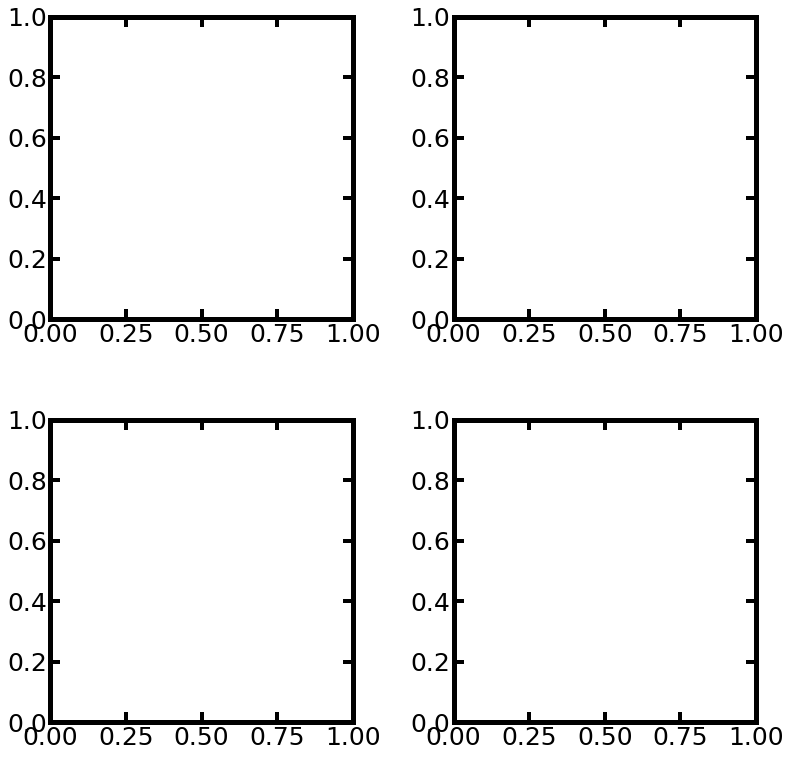

In [ ]:
def get_radius(fitsfile, band='b6', index=None, dist_kpc = 5.41):
 
    fits = Table.read(fitsfile)
    major = fits['deconvolved_major_%s'%band]
    minor = fits['deconvolved_minor_%s'%band]
    if index is None:
        index = np.arange(len(major))
    
    avg_size = np.sqrt(major * minor)[index]
    radius_au = avg_size * np.pi/180 * dist_kpc *1000*206264.806 *2/2.355
    return radius_au

fig = plt.figure(figsize=(14,14))
ax1 = fig.add_axes([0.1,0.1,0.3,0.3])
ax2 = fig.add_axes([0.5,0.1,0.3,0.3])
ax3 = fig.add_axes([0.1,0.5,0.3,0.3])
ax4 = fig.add_axes([0.5,0.5,0.3,0.3])

w51e_b6_rad = get_radius(w51e_dendro_matched_catalog)

w51e_b3_rad = get_radius(w51e_dendro_matched_catalog,band='b3')

w51n_b6_rad = get_radius(w51n_dendro_matched_catalog, dist_kpc=5.1)

w51n_b3_rad = get_radius(w51n_dendro_matched_catalog,  band='b3', dist_kpc=5.1)

ax1.scatter(w51e_b6_rad, w51e_b6_mass, c='b', s=10, label='B6')
ax1.scatter(w51e_b3_rad, w51e_b3_mass, c='orange', s=10, label='B3')
ax2.scatter(w51n_b6_rad, w51n_b6_mass, c='b', s=10, label='B6')
ax2.scatter(w51n_b3_rad, w51n_b3_mass, c='orange', s=10, label='B3')
ax3.scatter(w51e_b6_rad, w51e_b6_mass2, c='b', s=10, label='B6')
ax3.scatter(w51e_b3_rad, w51e_b3_mass2, c='orange', s=10, label='B3')
ax4.scatter(w51n_b6_rad, w51n_b6_mass2, c='b', s=10, label='B6')
ax4.scatter(w51n_b3_rad, w51n_b3_mass2, c='orange', s=10, label='B3')

ax1.set_xlabel('rad (AU)')
ax2.set_xlabel('rad (AU)')
ax3.set_xlabel('rad (AU)')
ax4.set_xlabel('rad (AU)')

ax1.set_ylabel('mass using 50K (Msun)')
ax2.set_ylabel('mass using 50K (Msun)')
ax3.set_ylabel('mass from BB (Msun)')
ax4.set_ylabel('mass from BB (Msun)')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax1.set_xlim(0,600)
ax2.set_xlim(0,600)
ax3.set_xlim(0,600)
ax4.set_xlim(0,600)
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')

ax1.set_ylim(1e-3,1e2)
ax2.set_ylim(1e-3,1e2)
ax3.set_ylim(1e-3,1e2)
ax4.set_ylim(1e-3,1e2)

ax1.set_title('W51-E')
ax2.set_title('W51-IRS2')
ax3.set_title('W51-E')
ax4.set_title('W51-IRS2')